# Multi-label Disease Classification of Chest X-Ray Images

UC San Diego Machine Learning Engineering Bootcamp

Tung Nguyen

## Introduction

Dataset: NIH Chest X-Rays from Kaggle, https://www.kaggle.com/nih-chest-xrays/data

This notebook contains the best performing models from Rounds 1 - 4 of tuning, trained on the full dataset.

## Imports
---

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split

from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as preprocess_input_Xc

from tensorflow.keras.applications import DenseNet169, DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_dn

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from sklearn.metrics import roc_curve, auc, precision_recall_curve, multilabel_confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 2022

train_size = 0.8
val_size = 0.2
test_size = 0.25

In [3]:
data_dir = '/Users/tungnguyen/Documents/capstone/data/'

## Data Preprocessing
---

### Wrangling

In [4]:
# Read CSV
df = pd.read_csv('/Users/tungnguyen/Documents/capstone/Data_Entry_2017.csv')

# Drop unnecessary columns
df.drop(['OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis=1, inplace=True)
print('Original DataFrame shape = {}'.format(df.shape))

# Some patients have age >200 - impute with mean of age from rows with the same Patient ID
err = df[df['Patient Age'] > 100]
df_dropped = df[df['Patient Age'] < 100]

for ind, row in err.iterrows():
    pid = row['Patient ID']
    avg = df_dropped[df_dropped['Patient ID'] == pid]['Patient Age'].mean()
    df.iat[ind, 4] = int(avg) if not(np.isnan(avg)) else -1

# There are ~3 patients with just a single datapoint - drop these 3 data points
df = df[df['Patient Age'] != -1]
df.reset_index(inplace=True)
print('Wrangled DataFrame shape = {}'.format(df.shape))

# Replace "No Finding" labels with blank
df['Finding Labels'] = df['Finding Labels'].replace(to_replace='No Finding', value='')

# Binarize
mlb = MultiLabelBinarizer()
lbl = mlb.fit_transform(df['Finding Labels'].str.split("|"))
df_mlb = pd.DataFrame(lbl, columns=mlb.classes_, dtype=np.float32)

# Drop 'No Finding' column
df_mlb.drop('', axis=1, inplace=True)

# Merge with main df
df = df.join(df_mlb)
print('Binarized DataFrame shape = {}'.format(df.shape))

# Get list of all labels
labels = [x for x in mlb.classes_ if x != '']
print()
print(labels)

Original DataFrame shape = (112120, 7)
Wrangled DataFrame shape = (112117, 8)
Binarized DataFrame shape = (112117, 22)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Splitting

In [5]:
tab_data_cols = ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']
X = df[tab_data_cols]
y = df[labels]

X_train, y_train, X_test, y_test = iterative_train_test_split(
    X.to_numpy(), 
    y.to_numpy(), 
    test_size=test_size,
)

In [6]:
# Convert matrices to DataFrames for Keras' flow_from_dataframe
train_df = pd.DataFrame(
    np.hstack((X_train, y_train)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

test_df = pd.DataFrame(
    np.hstack((X_test, y_test)),
    columns=[item for sublist in [tab_data_cols, labels] for item in sublist]
)

# Convert labels to float32 for Keras training
for col in train_df:
    if col in labels:
        train_df[col] = train_df[col].astype(np.float32)
        
for col in test_df:
    if col in labels:
        test_df[col] = test_df[col].astype(np.float32)

### Sampling

In [7]:
plt.style.use('tableau-colorblind10')

In [8]:
def plot_df_freq(df, labels, offset=500, title='Frequency of Positive Labels'):
    df_pos = df[labels].sum()

    ax = df_pos.plot(kind='bar', figsize=(15, 7), rot=20);
    ax.set_title(title);
    ax.set_xlabel('Labels');
    ax.set_ylabel('Frequency');

    for i, val in enumerate(df_pos.values):
        ax.text(i, val + offset, int(val), ha = 'center')
        
    return df_pos

In [9]:
weights = []
for i, lbl in enumerate(labels):
    weights.append(dict(enumerate(compute_class_weight(class_weight='balanced', classes=[0., 1.], y=train_df[lbl]))))

# Normalized class weights for weighted loss
pos = np.array([])
neg = np.array([])
for d in weights:
    pos = np.append(pos, d[1] / sum(d.values()))
    neg = np.append(neg, d[0] / sum(d.values())) 
    
# Non-normalized class weights for weighted loss
pos_2 = np.array([])
neg_2 = np.array([])
for d in weights:
    pos_2 = np.append(pos_2, d[1])
    neg_2 = np.append(neg_2, d[0])

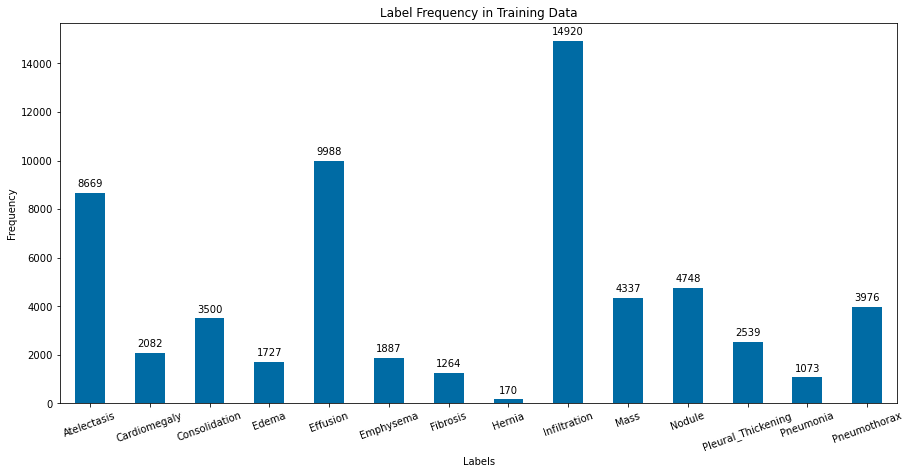

In [10]:
df_freq = plot_df_freq(train_df, labels, offset=250, title='Label Frequency in Training Data')

Atelectasis           5228.0
Cardiomegaly          1648.0
Consolidation         2801.0
Edema                 1526.0
Effusion              6434.0
Emphysema             1566.0
Fibrosis              1089.0
Hernia                 170.0
Infiltration          6950.0
Mass                  3095.0
Nodule                3066.0
Pleural_Thickening    2018.0
Pneumonia             1009.0
Pneumothorax          2775.0
dtype: float32

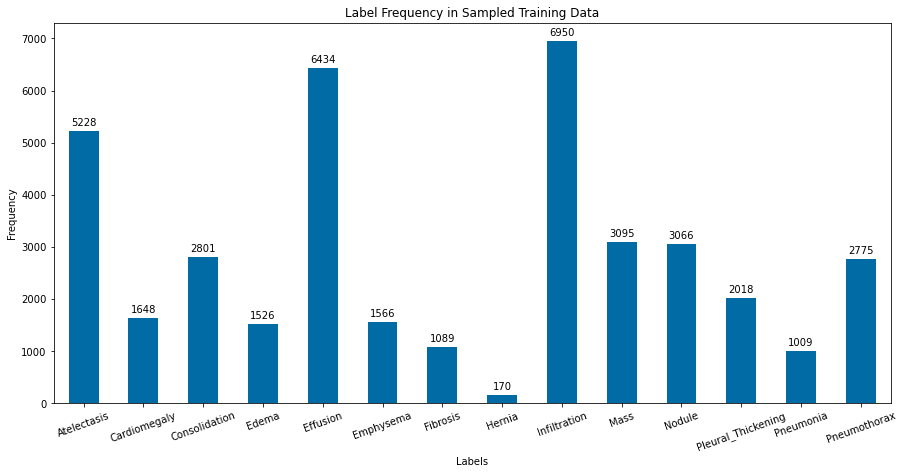

In [11]:
sample_weights = compute_sample_weight(class_weight=weights, y=train_df[labels])
train_df['sample_weights'] = sample_weights

sampled_train_df = train_df.sample(
    20000, 
    weights=sample_weights,
    random_state=random_state
)

plot_df_freq(sampled_train_df, labels, offset=100, title='Label Frequency in Sampled Training Data')

Atelectasis           1503.0
Cardiomegaly           252.0
Consolidation          701.0
Edema                  564.0
Effusion              1900.0
Emphysema             1748.0
Fibrosis              1715.0
Hernia                  29.0
Infiltration          3684.0
Mass                  2329.0
Nodule                2310.0
Pleural_Thickening    2070.0
Pneumonia             1629.0
Pneumothorax           920.0
dtype: float32

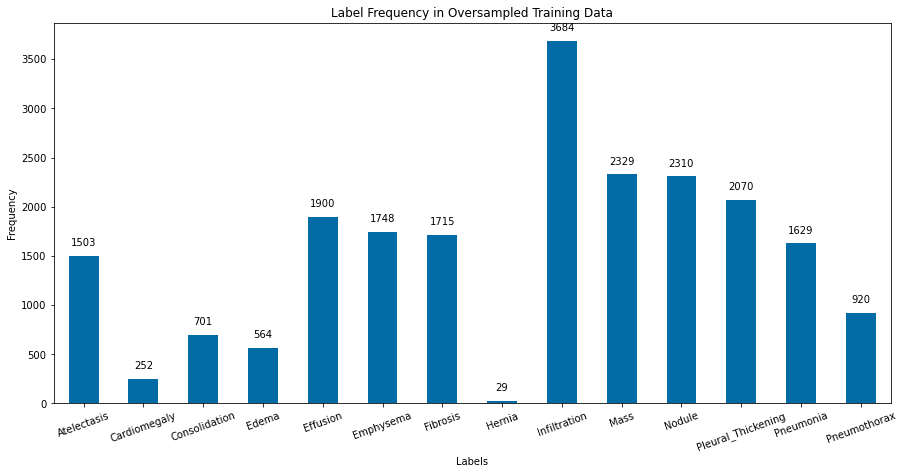

In [12]:
oversampled_train_df = pd.DataFrame([])

n = 1500

# Labels with lowest AUC from Model 6
low_auc_labels = ['Pneumonia', 'Nodule', 'Mass', 'Pleural_Thickening', 'Fibrosis', 'Infiltration', 'Emphysema']

# Sample each label
for lbl in low_auc_labels:
    temp = train_df[train_df[lbl] == 1].sample(
        n,
        replace=True,
        random_state=random_state
    )
    
    oversampled_train_df = pd.concat([oversampled_train_df, temp])
    
# Sample null label
temp = train_df[train_df['Finding Labels'] == ''].sample(
    n,
    replace=False,
    random_state=random_state
)
oversampled_train_df = pd.concat([oversampled_train_df, temp])

plot_df_freq(oversampled_train_df, labels, offset=100, title='Label Frequency in Oversampled Training Data')

In [13]:
def get_weighted_loss(pos, neg, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos)):
            loss += -1 * K.mean(pos * y_true * K.log(y_pred + epsilon) + 
                          (1 - y_true) * neg * K.log(1 - y_pred + epsilon))      
        return loss
    return weighted_loss

### Helper Functions

In [14]:
def plot_losses(model_history, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(model_history.history['val_loss'], 'r-o')
    ax.plot(model_history.history['loss'], 'b-o')
    ax.set_title('Training vs. Validation Loss')
    ax.legend(['Validation Loss', 'Training Loss'])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

def plot_roc_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        fpr, tpr, thresholds = roc_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % (lbl, auc(fpr, tpr)))
        print("AUC = %0.4f for %s" % (auc(fpr, tpr), lbl))

    ax.legend()
    ax.set_title('ROC Curves for Test Data - ' + model_name);
    ax.set_xlabel('False Positive Rate (FPR)');
    ax.set_ylabel('True Positive Rate (TPR)');

def plot_precision_recall_auc(y_pred, test_df, labels, model_name, figsize=(15, 10)):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, lbl in enumerate(labels):
        pr, rc, thresholds = precision_recall_curve(test_df[lbl].to_numpy(), y_pred[:, i])
        ax.plot(rc, pr, label = '%s (AUC: %0.4f)'  % (lbl, auc(rc, pr)))
        print("AUC = %0.4f for %s" % (auc(rc, pr), lbl))

    ax.legend()
    ax.set_title('Precision-Recall Curves for Test Data - ' + model_name);
    ax.set_xlabel('Recall');
    ax.set_ylabel('Precision');

In [15]:
def datagen_from_df(train_df, test_df, x_col, y_cols, data_path, preproc_func=None,
                    target_size=(256, 256), val_split=0.2, batch_size=64, sample_size=1000, color_mode='rgb', 
                    sample_center=False, sample_std=False, feature_center=False, feature_std=False, rescale_factor=None, 
                    weight_col=None, random_state=2022):

    datagen = ImageDataGenerator(
        preprocessing_function=preproc_func,
        validation_split=val_split,
        samplewise_center=sample_center,
        samplewise_std_normalization=sample_std,
        featurewise_center=feature_center,
        featurewise_std_normalization=feature_std,
        rescale=rescale_factor,
        horizontal_flip = True, 
        vertical_flip = False, 
        height_shift_range= 0.05, 
        width_shift_range=0.1, 
        rotation_range=5, 
        shear_range = 0.1,
        fill_mode = 'reflect',
        zoom_range=0.15,
    )

    if feature_center or feature_std:
        raw_train_generator = ImageDataGenerator().flow_from_dataframe(
            train_df,   
            data_path,
            shuffle=True,
            batch_size=sample_size,
            class_mode='raw',
            color_mode=color_mode,
            target_size=target_size,
            x_col=x_col,
            y_col=y_cols,
            seed=random_state
        )

        first_batch = raw_train_generator.next()
        data_sample = first_batch[0]
        datagen.fit(data_sample, augment=False, rounds=1, seed=random_state)

    train_generator = datagen.flow_from_dataframe(
        train_df,   
        data_path,
        shuffle=True,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        weight_col=weight_col,
        subset='training',
        seed=random_state
    )

    validation_generator = datagen.flow_from_dataframe(
        train_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        subset='validation',
        seed=random_state
    )

    test_generator = datagen.flow_from_dataframe(
        test_df,
        data_path,
        shuffle=False,
        batch_size=batch_size,
        class_mode='raw',
        color_mode=color_mode,
        target_size=target_size,
        x_col=x_col,
        y_col=y_cols,
        seed=random_state
    )
    
    return train_generator, validation_generator, test_generator

In [16]:
# Callbacks
early = EarlyStopping(
    monitor="val_loss",
    mode="min", 
    patience=8
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=4, 
    min_lr=0.001
)

## Scaled DL Prototype
---

### DataGenerators

In [17]:
train_generator_Xc, valid_generator_Xc, test_generator_Xc = datagen_from_df(
    train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_Xc,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 67270 validated image filenames.
Found 16817 validated image filenames.
Found 28030 validated image filenames.


In [18]:
train_generator_dn, valid_generator_dn, test_generator_dn = datagen_from_df(
    train_df, test_df, x_col='Image Index', y_cols=labels, data_path=data_dir, preproc_func=preprocess_input_dn,
    target_size=(256, 256), val_split=val_size, batch_size=64, color_mode='rgb', 
    sample_center=False, sample_std=False, feature_center=False, feature_std=False,
    weight_col=None, rescale_factor=None
)

Found 67270 validated image filenames.
Found 16817 validated image filenames.
Found 28030 validated image filenames.


### Model 11: Xception (Scaled)

In [19]:
# Base Model
base_model_Xc = Xception(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer = Dense(len(labels), activation='sigmoid')(base_model_Xc.output)
model_Xc = Model(base_model_Xc.input, output_layer)

for layer in model_Xc.layers:
    layer.trainable = True

#model_Xc.summary()

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-02-07 19:40:58.173554: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-07 19:40:58.173671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
model_Xc.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [21]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/Xception-model-11-scaled.h5'

chkpt_Xc = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [22]:
%%time
history_Xc = model_Xc.fit(
    train_generator_Xc, 
    validation_data=valid_generator_Xc,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_Xc, early, reduce_lr]
)

2022-02-07 19:40:59.931549: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/40


2022-02-07 19:41:01.197036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1052/1052 [==============================] - ETA: 0s - loss: 0.8071

2022-02-07 20:02:37.247740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.60387, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/Xception-model-11-scaled.h5
1052/1052 [==============================] - 1575s 1s/step - loss: 0.8071 - val_loss: 0.6039 - lr: 0.0010
Epoch 2/40
1052/1052 [==============================] - ETA: 0s - loss: 0.7540
Epoch 00002: val_loss did not improve from 0.60387
1052/1052 [==============================] - 1567s 1s/step - loss: 0.7540 - val_loss: 0.6301 - lr: 0.0010
Epoch 3/40
1052/1052 [==============================] - ETA: 0s - loss: 0.7291
Epoch 00003: val_loss improved from 0.60387 to 0.56748, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/Xception-model-11-scaled.h5
1052/1052 [==============================] - 1568s 1s/step - loss: 0.7291 - val_loss: 0.5675 - lr: 0.0010
Epoch 4/40
1052/1052 [==============================] - ETA: 0s - loss: 0.7161
Epoch 00004: val_loss did not improve from 0.56748
1052/1052 [=======

In [23]:
y_pred_Xc = model_Xc.predict(test_generator_Xc, batch_size=64, verbose=True)

2022-02-08 04:46:22.116761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 451s 1s/step


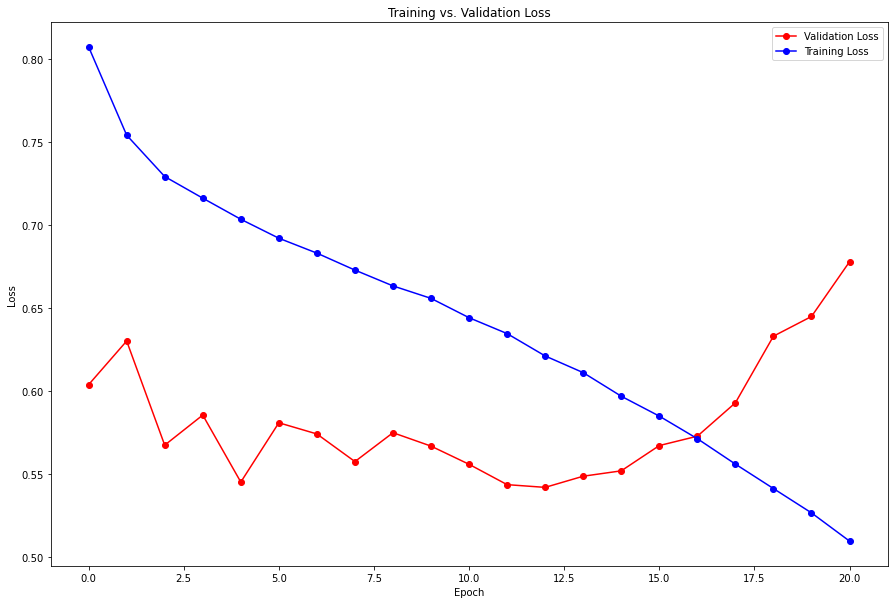

In [24]:
plot_losses(history_Xc)

AUC = 0.7577 for Atelectasis
AUC = 0.8823 for Cardiomegaly
AUC = 0.7675 for Consolidation
AUC = 0.8699 for Edema
AUC = 0.8434 for Effusion
AUC = 0.9068 for Emphysema
AUC = 0.7728 for Fibrosis
AUC = 0.8886 for Hernia
AUC = 0.6194 for Infiltration
AUC = 0.8291 for Mass
AUC = 0.7213 for Nodule
AUC = 0.7563 for Pleural_Thickening
AUC = 0.6917 for Pneumonia
AUC = 0.8583 for Pneumothorax


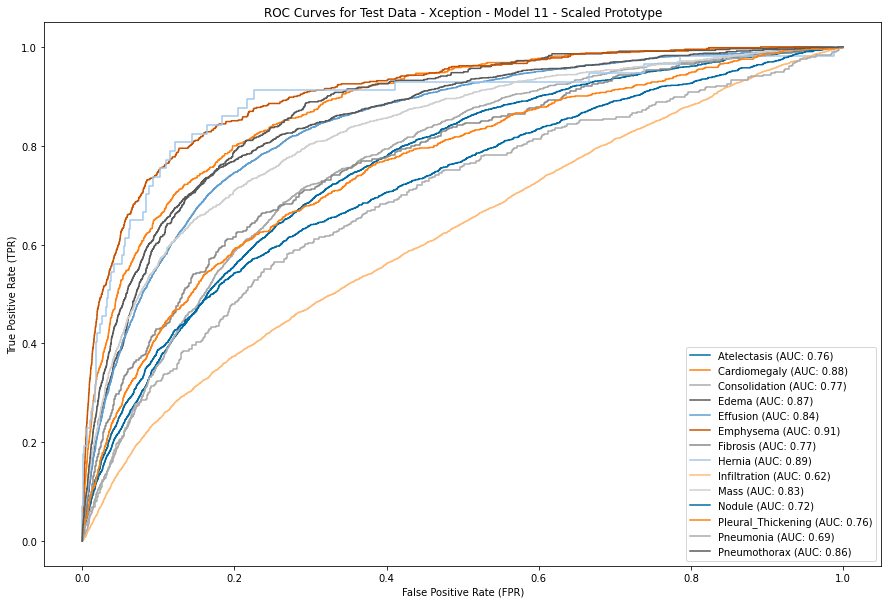

In [25]:
plot_roc_auc(y_pred_Xc, test_df, labels, model_name='Xception - Model 11 - Scaled Prototype')

### Model 13.1: DenseNet169 (Scaled)

In [26]:
base_model_dn169 = DenseNet169(
    include_top=False,
    weights="imagenet",
    pooling="avg",
    input_shape=(256, 256, 3)
)

output_layer = Dense(len(labels), activation='sigmoid')(base_model_dn169.output)
model_dense169 = Model(base_model_dn169.input, output_layer)

for layer in model_dense169.layers:
    layer.trainable = True
    
#model_dense169.summary()

In [27]:
model_dense169.compile(
    optimizer='adam',
    loss=get_weighted_loss(pos, neg)
)

In [28]:
model_path = '/Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/DenseNet169-model-13-1-scaled.h5'

chkpt_dense169 = ModelCheckpoint(
    model_path, 
    monitor='val_loss',
    verbose=1, 
    save_best_only=True, 
    mode='min', 
    save_weights_only = True
)

In [29]:
%%time
history_dense169 = model_dense169.fit(
    train_generator_dn, 
    validation_data=valid_generator_dn,
    #steps_per_epoch=100, 
    #validation_steps=25, 
    epochs = 40,
    callbacks = [chkpt_dense169, early, reduce_lr]
)

Epoch 1/40


2022-02-08 04:53:59.905523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1052/1052 [==============================] - ETA: 0s - loss: 0.8383

2022-02-08 05:18:01.050902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.90497, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/DenseNet169-model-13-1-scaled.h5
1052/1052 [==============================] - 1726s 2s/step - loss: 0.8383 - val_loss: 0.9050 - lr: 0.0010
Epoch 2/40
1052/1052 [==============================] - ETA: 0s - loss: 0.7885
Epoch 00002: val_loss improved from 0.90497 to 0.63893, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/DenseNet169-model-13-1-scaled.h5
1052/1052 [==============================] - 1716s 2s/step - loss: 0.7885 - val_loss: 0.6389 - lr: 0.0010
Epoch 3/40
1052/1052 [==============================] - ETA: 0s - loss: 0.7649
Epoch 00003: val_loss improved from 0.63893 to 0.56911, saving model to /Users/tungnguyen/Documents/repos/mec-capstone/Scaled_Prototype/DenseNet169-model-13-1-scaled.h5
1052/1052 [==============================] - 1723s 2s/step - loss: 0.7649 - val_loss: 0.5691 - lr: 0.0010
Epoch 4/40
1052/1052

In [30]:
y_pred_dn = model_dense169.predict(test_generator_dn, batch_size=64, verbose=True)

2022-02-08 16:50:08.462131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 476s 1s/step


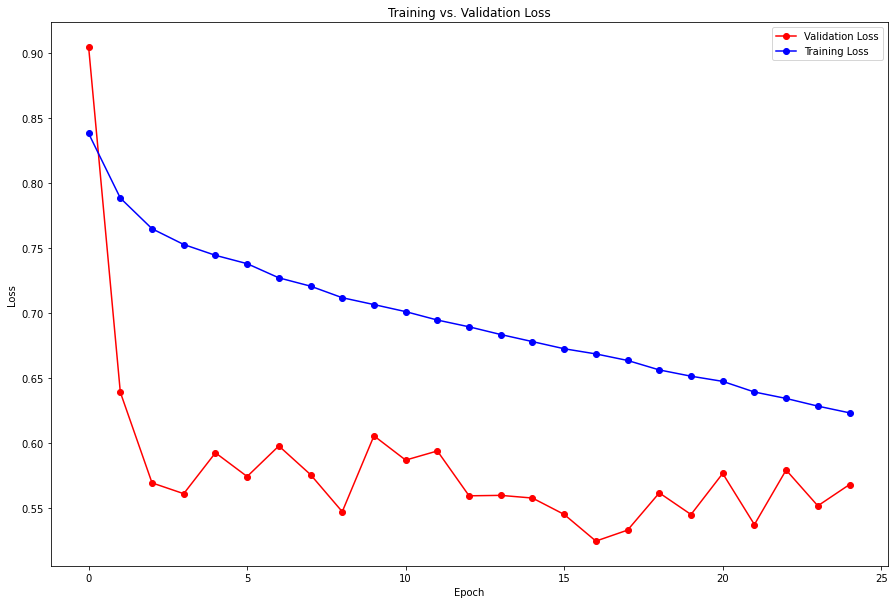

In [31]:
plot_losses(history_dense169)

AUC = 0.7888 for Atelectasis
AUC = 0.9043 for Cardiomegaly
AUC = 0.7779 for Consolidation
AUC = 0.8882 for Edema
AUC = 0.8545 for Effusion
AUC = 0.8814 for Emphysema
AUC = 0.7688 for Fibrosis
AUC = 0.9228 for Hernia
AUC = 0.6555 for Infiltration
AUC = 0.8320 for Mass
AUC = 0.7223 for Nodule
AUC = 0.7595 for Pleural_Thickening
AUC = 0.7376 for Pneumonia
AUC = 0.8424 for Pneumothorax


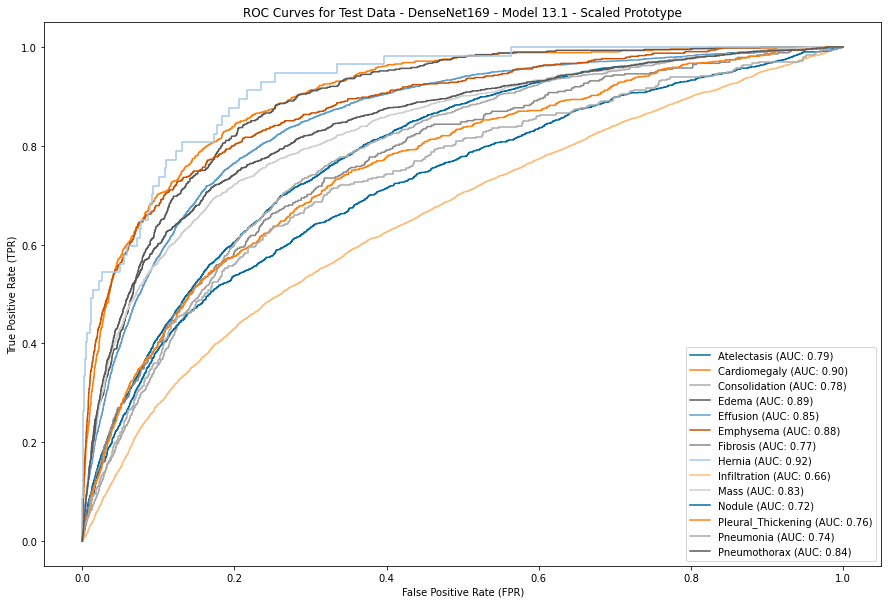

In [32]:
plot_roc_auc(y_pred_dn, test_df, labels, model_name='DenseNet169 - Model 13.1 - Scaled Prototype')